<a href="https://colab.research.google.com/github/Diandra2607/Electric_Production/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
col_names = ["date", "value"]
data = pd.read_csv('/content/Electric_Production.csv',
                 names = col_names, header = 0, parse_dates = [0])
data['date'] = pd.to_datetime(data['date'],infer_datetime_format=True)
data = data.set_index(['date'])

<ipython-input-2-264dedea502c>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['date'] = pd.to_datetime(data['date'],infer_datetime_format=True)


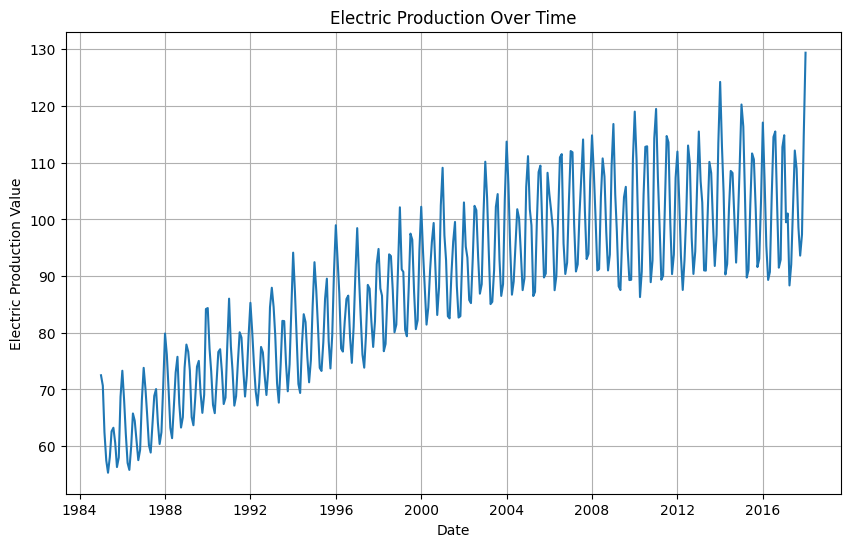

In [ ]:
# Plotting the data
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(data.index, data['value'])
plt.xlabel("Date")
plt.ylabel("Electric Production Value")
plt.title("Electric Production Over Time")
plt.grid(True)  # Add a grid for better readability
plt.show()

In [ ]:
import statsmodels
import scipy

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import kstest, boxcox
import numpy as np

ADF Statistic: -2.195665792210388
p-value: 0.20782228347009452
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


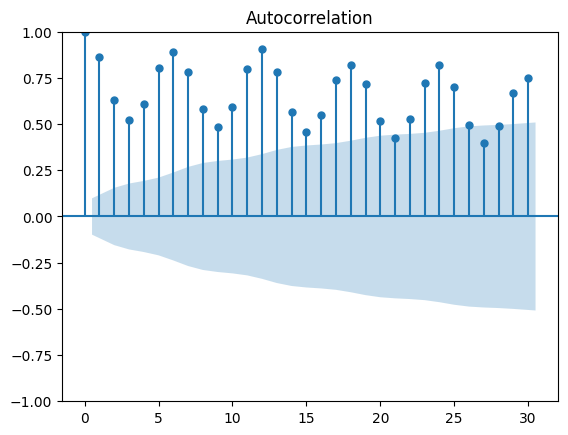

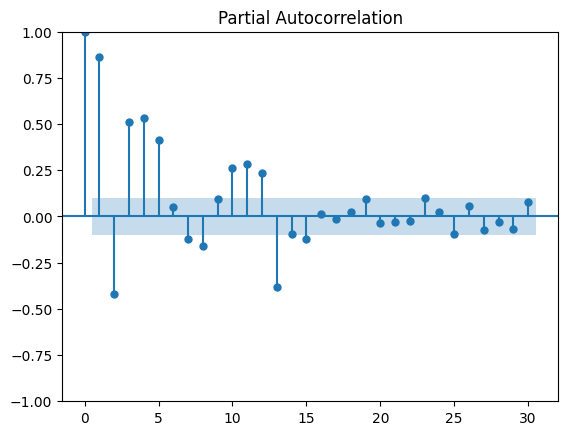

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           value_boxcox   No. Observations:                  397
Model:                ARIMA(12, 0, 1)   Log Likelihood               -1110.523
Date:                Wed, 15 Jan 2025   AIC                           2251.046
Time:                        03:45:40   BIC                           2310.805
Sample:                    01-01-1985   HQIC                          2274.719
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.8495     29.104      3.946      0.000      57.807     171.892
ar.L1          0.0619      0.052      1.182      0.237      -0.041       0.164
ar.L2          0.1572      0.059      2.649      0.0

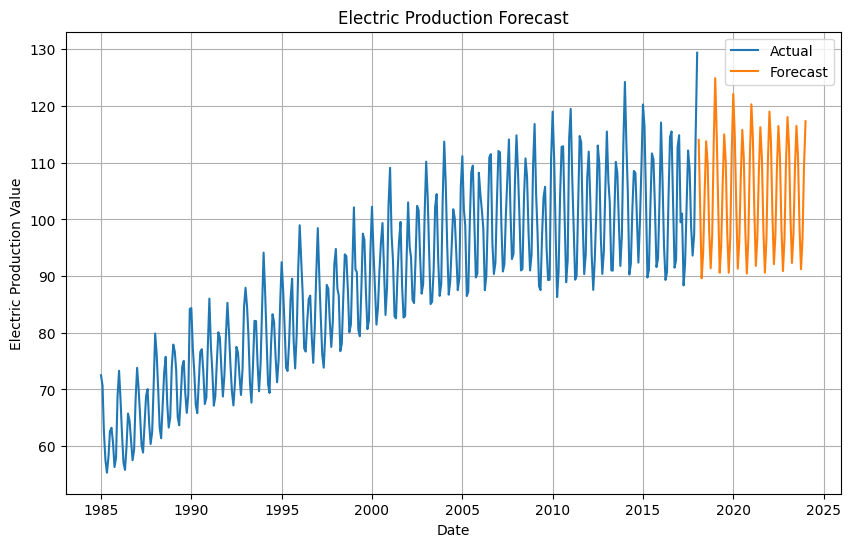

In [ ]:
# Check for variance stationarity using Box-Cox transformation
data['value_boxcox'], lmbda = boxcox(data['value'])

# Check stationarity of the mean using Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adf_test(data['value_boxcox'])


# Determine ARIMA order (p, d, q) based on ACF and PACF
plot_acf(data['value_boxcox'], lags=30); plt.show()
plot_pacf(data['value_boxcox'], lags=30); plt.show()

# Assuming you visually determined the orders, substitute (p, d, q) values below
p, d, q = (12, 0, 1) # Replace with your determined orders

# Fit the ARIMA model
model = ARIMA(data['value_boxcox'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Diagnostic Checks
# Ljung-Box test for residual autocorrelation
lb_result = acorr_ljungbox(model_fit.resid, lags=[10]) # Lag is arbitrary

# Kolmogorov-Smirnov test for residual normality
ks_result = kstest(model_fit.resid, 'norm')
print(f"Kolmogorov-Smirnov Test: p-value = {ks_result[1]}")

# Forecast for the next 6 years
forecast_steps = 6 * 12  # Assuming monthly data
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Inverse Box-Cox transformation to obtain actual values
forecast_invboxcox = np.exp(np.log(forecast_mean*lmbda+1)/lmbda) # Inverse Box-Cox

# Create index for the forecasted period
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({'value': forecast_invboxcox}, index=forecast_index)

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], label='Actual')
plt.plot(forecast_df.index, forecast_df['value'], label='Forecast')
plt.xlabel("Date")
plt.ylabel("Electric Production Value")
plt.title("Electric Production Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast_df

,value
2018-02-01,114.032048
2018-03-01,102.647131
2018-04-01,89.614530
2018-05-01,93.898043
2018-06-01,104.574455
...,...
2023-09-01,98.594538
2023-10-01,91.210671
2023-11-01,96.609289
2023-12-01,109.471187
